In [1]:
from qick import *
%pylab inline

import time

from scipy.signal import welch
from numpy.fft import fftshift

from scipy.signal import spectrogram
from matplotlib import colors

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc()
soccfg = soc

print(soccfg)


QICK configuration:

	Board: ZCU111

	Software version: 0.2.181
	Firmware timestamp: Wed Aug 16 13:39:03 2023

	Global clocks (MHz): tProcessor 384.000, RF reference 204.800

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 0, blk 0, 32-bit DDS, fabric=384.000 MHz, f_dds=6144.000 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 0, blk 1, 32-bit DDS, fabric=384.000 MHz, f_dds=6144.000 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 0, blk 2, 32-bit DDS, fabric=384.000 MHz, f_dds=6144.000 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 1, blk 0, 32-bit DDS, fabric=384.000 MHz, f_dds=6144.000 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 1, blk 1, 32-bit DDS, fabric=384.000 MHz, f_dds=6144.000 MHz
	5:	axis_signal_gen_v6 - tProc output 6, envelope memory 65536 samples
		DAC ti

# setup
The board should be cabled in loopback; set the channel numbers and frequency here.

In [3]:
GEN_CH = 6
RO_CH = 0
FREQ = 250 # MHz

# some notes
Remember that the QICK readout works in two steps: first digital downconversion (multiplying by a complex sinusoid), then decimation (low-pass filter and downsample to reduce the bandwidth and sample rate by a factor of 8).

In normal readout, the decimated data stream goes to the average+buffer module which implements the "decimated" and "accumulated" readout modes. But we have additional buffer modules that can look at the data stream: the DDR4 and multi-rate buffers.

These behave similarly to the decimated readout (you get to fill a time window with IQ samples, I and Q are both signed int16).

### DDR4 buffer
The DDR4 buffer is fed by the downconverted+decimated data stream coming out of the readout, so you get one sample for each tick of the readout fabric clock.

The DDR4 readout fills the buffer in chunks of 128 or 256 samples (depending on firmware). When configuring the buffer, you specify the number of transfers.

You can zero out the buffer if you want, see next cell - this is totally optional.
It takes 4-5 seconds to clear 4 GiB.

The PL (FPGA-side) DDR4 we're using here is separate from the PS (CPU-side) DDR4, but they are the same size (though the PS DDR4 is user-replaceable and could be upgraded). 
So you should not actually try to get the entire contents of the DDR4 buffer at once, since that will make the OS sad. You probably don't want to work with a 4 GiB array anyway.

4 GiB, 2x16 bits per sample = 2^30 samples (as printed in the QickConfig), or 2^22 DDR4 transfers. At typical fabric clock speeds, this is a few seconds. You can ask for more transfers (you need to set `force_overwrite=True`), in which case the buffer will wrap around and later data will overwrite earlier data. Maybe someone will find a use for this, though it's hard to think of an application that doesn't require processing the data as fast as it is written (which would be hard or impossible).

### multi-rate (MR) buffer
The multi-rate buffer is fed by the downconverted but undecimated data stream coming out of the readout, so you get 8 samples per fabric tick, or 1 sample per ADC tick.

The MR readout always runs until the buffer is full.

In typical firmware images, the MR buffer holds 8 times as many samples as the decimated buffer, which means it can record for the same amount of time.

In [4]:
# clearing the DDR4 buffer - optional, but might be useful for debugging
t = time.time()
soc.clear_ddr4()
print(time.time() - t)

4.692858934402466


# example program
This is identical to the 00 loopback demo, with the addition of the DDR4 and MR triggers. So the only lines you should look at are at the end of `initialize()`.

You only need to trigger the special buffers once (later triggers are harmless but ignored).
So, you'd generally put the trigger in your `initialize()`.
If you specify an `adc_trig_offset`, that value will be applied.
You can also add the `ddr4=True` and `mr=True` options to any other trigger command.

In [5]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1, ro_ch=cfg["ro_chs"][0])
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(100)  # give processor some time to configure pulses
        self.trigger(ddr4=True, mr=True, adc_trig_offset=self.cfg["adc_trig_offset"])
        self.synci(100)  # give the buffers a little time
        
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
        # equivalent to the following:
#         self.trigger(adcs=self.ro_chs,
#                      pins=[0], 
#                      adc_trig_offset=self.cfg["adc_trig_offset"])
#         self.pulse(ch=self.cfg["res_ch"])
#         self.wait_all()
#         self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

# let's do a decimated readout
Note that if you arm a buffer and then run the program multiple times (such as by using soft_avgs/rounds, as we do here), the buffer will only start the first time.


In [6]:
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":500, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":1000, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": FREQ, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":10
        # Try varying soft_avgs from 1 to 200 averages

       }

prog =LoopbackProgram(soccfg, config)
prog.config_all(soc)

n_transfers = 100000 # each transfer (aka burst) is 256 decimated samples

# Arm the buffers
soc.arm_ddr4(ch=RO_CH, nt=n_transfers)
soc.arm_mr(ch=RO_CH)

# Run the program
iq_list = prog.acquire_decimated(soc, progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

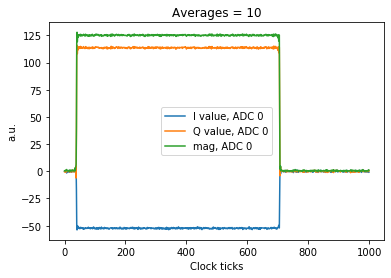

In [7]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();

## looking at DDR4 buffer
The DDR4 and decimated buffers capture identical data, but the DDR4 buffer has much more capacity.
You generally won't use the full capcity of the DDR4 buffer; only arm and read what you need.

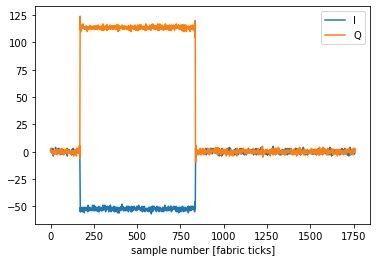

In [8]:
# let's look at the first pulse
iq_ddr4 = soc.get_ddr4(10)

plt.plot(iq_ddr4[:,0],label="I")
plt.plot(iq_ddr4[:,1],label="Q")
plt.xlabel("sample number [fabric ticks]")
plt.legend();

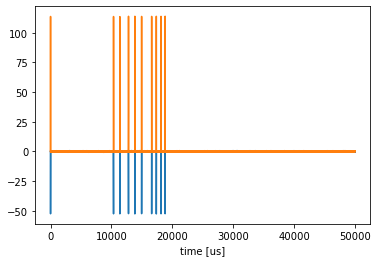

In [9]:
# let's look at the whole trace - we don't want to plot all the points, so let's do some averaging

iq_ddr4 = soc.get_ddr4(n_transfers)

chunksize = 100

iq_ddr4 = iq_ddr4[:(iq_ddr4.shape[0]//chunksize)*chunksize] # trim length to an even multiple of chunksize
iq_averaged = iq_ddr4.reshape((-1,chunksize,2)).mean(axis=1)
t = soccfg.cycles2us(np.arange(len(iq_averaged)), ro_ch=0)*chunksize
plt.plot(t,iq_averaged[:,0],label="I")
plt.plot(t,iq_averaged[:,1],label="Q")
plt.xlabel('time [us]');

# you can see the later soft_avg executions - if you catch them all, there should be 10 pulses

## looking at MR buffer
The MR buffer always captures and returns the full size of the buffer.

We're looking directly at the output of downconversion, which is the result of taking the real ADC signal (which is the sum of two complex tones at positive and negative frequencies) and shifting it by the RF frequency.
So we see both the down-mixed DC signal and an up-mixed 2\*RF image tone (which is normally filtered out by decimation). Typically the MR buffer is more useful with downconversion disabled - we'll look at this more later.

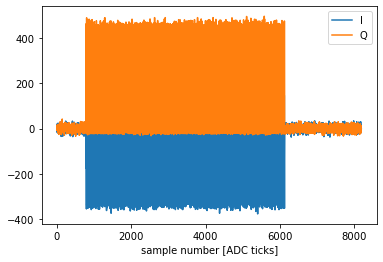

In [10]:
# let's look at the first pulse
iq_mr = soc.get_mr()
plt.plot(iq_mr[:,0],label="I")
plt.plot(iq_mr[:,1],label="Q")
plt.xlabel("sample number [ADC ticks]")
plt.legend();

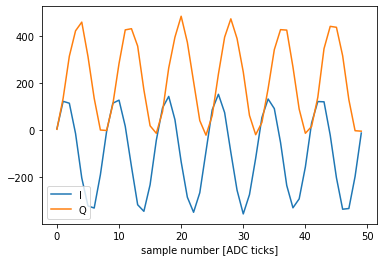

In [11]:
# zoom in and see the up-mixed image tone
plt.plot(iq_mr[2000:2050,0],label="I")
plt.plot(iq_mr[2000:2050,1],label="Q")
plt.xlabel("sample number [ADC ticks]")
plt.legend();

# now let's do an accumulated readout
The DDR4 buffer is totally independent of the program execution, so you can use it with acquire() or acquire_decimated() - this is sort of naturally useful for debugging, since you can take your normal experimental program, just enable the DDR4 buffer, and capture many reps' worth of decimated data


In [12]:
config2 = config.copy()
config2['soft_avgs'] = 1
config2['reps'] = 10

prog =LoopbackProgram(soccfg, config2)

n_transfers = 200

# Arm the buffer
soc.arm_ddr4(ch=RO_CH, nt=n_transfers)

# Run the program
# If you run the program multiple times (such as by using soft_avgs/rounds), the buffer will only start the first time.
iq_list = prog.acquire(soc, progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

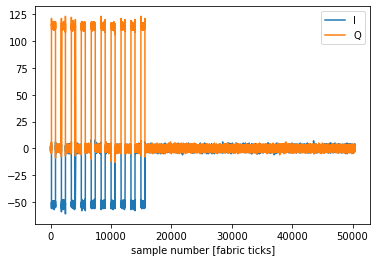

In [13]:
# we can see the whole program
iq = soc.get_ddr4(n_transfers)

plt.plot(iq[:,0],label="I")
plt.plot(iq[:,1],label="Q")
plt.xlabel("sample number [fabric ticks]")
plt.legend();

# just triggering the buffer
This is a minimal program that just triggers the buffer - so we just see noise.

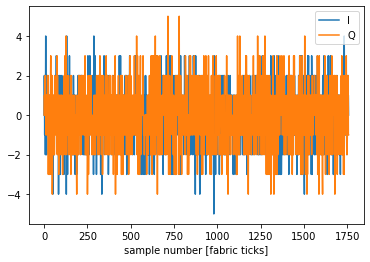

In [14]:
trigprog = QickProgram(soccfg)
trigprog.declare_readout(ch=RO_CH, freq=FREQ, length=100, gen_ch=GEN_CH)
trigprog.trigger(ddr4=True, mr=True)
trigprog.end()

n_transfers = 10

soc.arm_ddr4(ch=RO_CH, nt=n_transfers)
trigprog.config_all(soc)
soc.tproc.start()

iq = soc.get_ddr4(n_transfers)
plt.plot(iq[:,0],label="I")
plt.plot(iq[:,1],label="Q")
plt.xlabel("sample number [fabric ticks]")
plt.legend();

We can do some fun things like measure for a while and make a spectrogram (two examples). You could use this to debug noise?

By the way, you can see how the decimation low-pass filter kills the noise power at the edges of the spectrogram.

In [15]:
n_transfers = 1000

soc.arm_ddr4(ch=RO_CH, nt=n_transfers)
trigprog.config_all(soc)
soc.tproc.start()

iq = soc.get_ddr4(n_transfers)
complex_iq = iq.dot([1,1j])
f_fabric = soc['readouts'][0]['f_fabric']

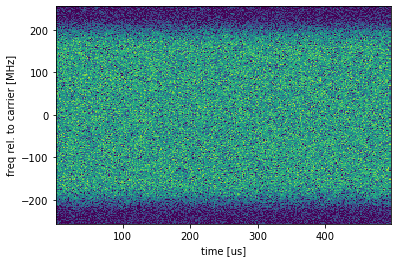

In [16]:
f, t, Sxx = spectrogram(complex_iq, fs=f_fabric, return_onesided=False, detrend=False, nperseg=1024)
f_draw = fftshift(f)
Sxx_draw = fftshift(Sxx, axes=0)
plt.pcolormesh(t, f_draw, Sxx_draw, norm=colors.LogNorm(vmin=0.5*np.min(np.mean(Sxx_draw,axis=1))), shading='auto')
plt.xlabel("time [us]")
plt.ylabel("freq rel. to carrier [MHz]");

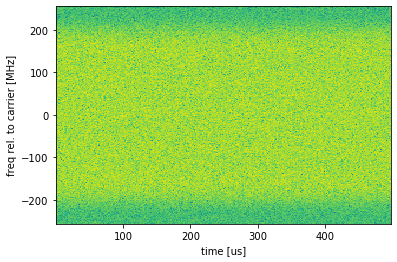

In [17]:
Pxx, freqs, bins, im = plt.specgram(complex_iq, NFFT=1024, Fs=f_fabric)
plt.xlabel("time [us]")
plt.ylabel("freq rel. to carrier [MHz]");

## playing with MR buffer
Let's play a continuous tone and look at it with the MR buffer.
First, we'll enable downconversion just like we did before.

In [18]:
toneprog = QickProgram(soccfg)
toneprog.declare_gen(ch=GEN_CH, nqz=1, ro_ch=RO_CH)
toneprog.set_pulse_registers(ch=GEN_CH, freq=soccfg.freq2reg(FREQ, gen_ch=GEN_CH, ro_ch=RO_CH), 
                         phase=0, gain=3000, mode='periodic',
                         style='const', length=10)
toneprog.pulse(ch=GEN_CH)
toneprog.end()

toneprog.config_all(soc)
soc.tproc.start()

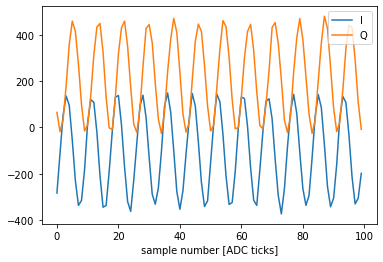

In [19]:
trigprog = QickProgram(soccfg)
trigprog.declare_readout(ch=RO_CH, freq=FREQ, length=100, gen_ch=GEN_CH)
trigprog.trigger(ddr4=True, mr=True)
trigprog.end()

# Arm the buffer
soc.arm_mr(ch=RO_CH)
trigprog.config_all(soc)
soc.tproc.start()

iq = soc.get_mr()

plt.plot(iq[:100,0],label="I")
plt.plot(iq[:100,1],label="Q")
# plt.plot(iq[:,0],label="I")
# plt.plot(iq[:,1],label="Q")
plt.xlabel("sample number [ADC ticks]")
plt.legend();

Again we see the 2\*RF image on top of the DC signal.
We can see this clearly in an FFT: the peak at DC is the down-mixed signal, the peak at 500 MHz is the image tone, the peak at 250 MHz is low-frequency noise.

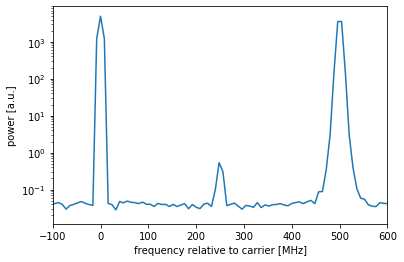

In [20]:
complex_iq = iq.dot([1,1j])

fs_adc = soc['readouts'][RO_CH]['fs']

fft_freqs, psd = fftshift(welch(complex_iq, fs_adc, return_onesided=False, detrend=False, nperseg=512), axes=1)
plt.semilogy(fft_freqs, psd)
plt.xlim((-100,600))
plt.xlabel("frequency relative to carrier [MHz]")
plt.ylabel("power [a.u.]");

Now let's disable downconversion.
The buffer gives us purely real data, which is as close as we can get to seeing the raw ADC data.

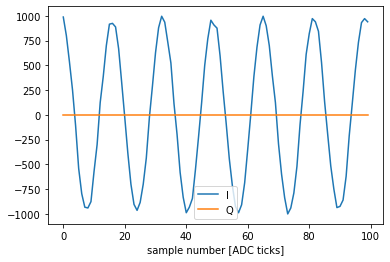

In [21]:
trigprog = QickProgram(soccfg)
trigprog.declare_readout(ch=RO_CH, freq=FREQ, length=100, sel='input')
trigprog.trigger(ddr4=True, mr=True)
trigprog.end()

soc.arm_mr(ch=RO_CH)

trigprog.config_all(soc)
soc.tproc.start()

iq = soc.get_mr()

plt.plot(iq[:100,0],label="I")
plt.plot(iq[:100,1],label="Q")
plt.xlabel("sample number [ADC ticks]")
plt.legend();

Now the FFT shows the noise and signal at their true frequencies.
Note that because the MR buffer sees the data before decimation, the frequency range goes up to the Nyquist frequency. Any signal, of whatever frequency, will show up here.
This makes the MR buffer useful for debugging noise or spurs without bringing in a spectrum analyzer.

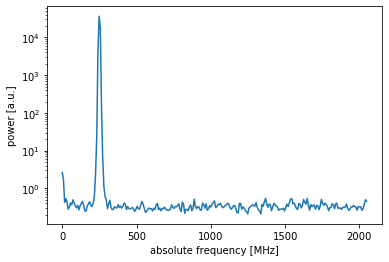

In [22]:
complex_iq = iq.dot([1,1j])

fs_adc = soc['readouts'][RO_CH]['fs']

fft_freqs, psd = welch(iq[:,0], fs_adc, return_onesided=True, detrend=False, nperseg=512)
plt.semilogy(fft_freqs, psd)
plt.xlabel("absolute frequency [MHz]")
plt.ylabel("power [a.u.]");

Let's turn off the tone and look again: we only see the low-frequency noise.

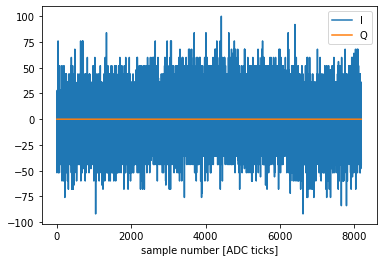

In [23]:
soc.reset_gens()

trigprog = QickProgram(soccfg)
trigprog.declare_readout(ch=RO_CH, freq=FREQ, length=100, sel='input')
trigprog.trigger(ddr4=True, mr=True)
trigprog.end()

# Arm the buffer
soc.arm_mr(ch=RO_CH)
trigprog.config_all(soc)
soc.tproc.start()

iq = soc.get_mr()

plt.plot(iq[:,0],label="I")
plt.plot(iq[:,1],label="Q")
plt.xlabel("sample number [ADC ticks]")
plt.legend();

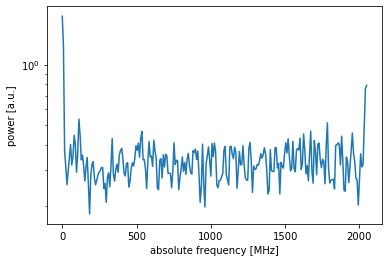

In [24]:
fs_adc = soc['readouts'][RO_CH]['fs']

fft_freqs, psd = welch(iq[:,0], fs_adc, return_onesided=True, detrend=False, nperseg=512)
plt.semilogy(fft_freqs, psd)
plt.xlabel("absolute frequency [MHz]")
plt.ylabel("power [a.u.]");

# extra: junk data
The readout logic in both buffers hold some stale data - some data at the end of each readout is lost and shows up at the start of the buffer in the next readout. Normally this junk data is dropped, so you don't need to worry about it (you will just notice that you get slightly less data than you might expect).

If we disable that cleanup logic, we can see the effect by doing one readout with a tone playing and a second readout with the tone off: the data from the second readout should just be noise, but instead we see the tone at the start of each buffer. We can confirm that the "junk length" configured in the QICK library is correct.

In [25]:
# Start playing a tone
toneprog = QickProgram(soccfg)
toneprog.declare_gen(ch=GEN_CH, nqz=1, ro_ch=RO_CH)
toneprog.set_pulse_registers(ch=GEN_CH, freq=soccfg.freq2reg(FREQ, gen_ch=GEN_CH, ro_ch=RO_CH), 
                         phase=0, gain=3000, mode='periodic',
                         style='const', length=10)
toneprog.pulse(ch=GEN_CH)
toneprog.end()

toneprog.config_all(soc)
soc.tproc.start()

# Arm the buffer and do a readout
trigprog = QickProgram(soccfg)
trigprog.declare_readout(ch=RO_CH, freq=FREQ, length=100, gen_ch=GEN_CH)
trigprog.trigger(ddr4=True, mr=True)
trigprog.end()

soc.arm_mr(ch=RO_CH)
soc.arm_ddr4(ch=RO_CH, nt=10)
trigprog.config_all(soc)
soc.tproc.start()

# Turn off the continuous tone
soc.reset_gens()

# Arm the buffer and do a readout
soc.arm_mr(ch=RO_CH)
soc.arm_ddr4(ch=RO_CH, nt=10)
trigprog.config_all(soc)
soc.tproc.start()

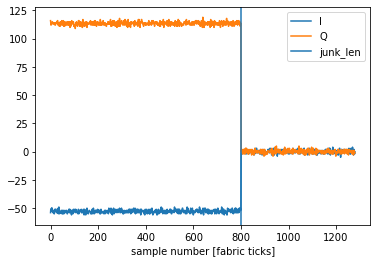

In [26]:
iq = soc.get_ddr4(5, start=0)
plt.plot(iq[:,0],label="I")
plt.plot(iq[:,1],label="Q")
plt.xlabel("sample number [fabric ticks]")
plt.axvline(soccfg['ddr4_buf']['junk_len'], label='junk_len')
plt.legend();

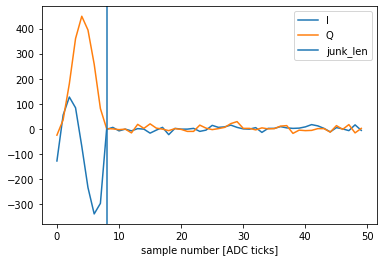

In [27]:
iq = soc.get_mr(start=0)
plt.plot(iq[:50,0],label="I")
plt.plot(iq[:50,1],label="Q")
plt.xlabel("sample number [ADC ticks]")
plt.axvline(soccfg['mr_buf']['junk_len'], label='junk_len')
plt.legend();